In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

In [30]:
IMAGE_BATCH = 256
BATCH_SIZE = 32
CHANNEL = 3
EPOCS = 50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_BATCH,IMAGE_BATCH),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [11]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [16]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


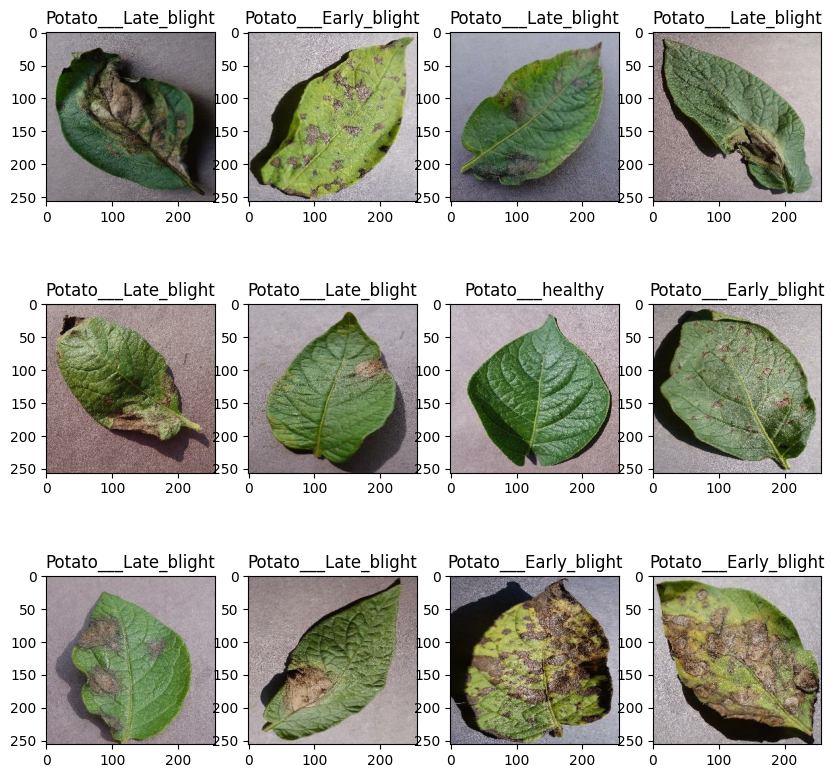

In [29]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_name[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype('uint8'))

In [39]:
def get_dataset_partitions(ds, train_split = 0.8,val_split = 0.1,test_split = 0.1,shuffle = True,shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed = 12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(val_size)
    testing_ds = ds.skip(train_size).skip(val_size)

    return train_ds,testing_ds,validation_ds


In [40]:
train_ds,test_ds,val_ds = get_dataset_partitions(dataset)

In [45]:
train_ds = train_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(10000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [46]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_BATCH,IMAGE_BATCH),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [49]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])